#  Ubiquant Market Prediction with DNN
In this notebook, I will build a Ubiquant Market Prediction Model with TensorFlow DNN. 
I will train the Model using CombinatorialPurgedGroupKFold CV strategy. You can find more detials in this [discussion](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305118).
In other to train the Model for 5 folds in a single run and avoid OOM error, I made a TF-record dataset in notebook [UMP TF-Record: CombinatorialPurgedGroupKFold](https://www.kaggle.com/lonnieqin/ump-tf-record-combinatorialpurgedgroupkfold).
## Import Packages

In [2]:
# Google Colabで、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

#/root/.kaggleを作成して、apiを使えるようにする。
!sudo mkdir /root/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json /root/.kaggle/kaggle.json

# cdは!が使えない。マジックコマンド%で移動
%cd /content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction
%ls -a

Mounted at /content/drive
/content/drive/MyDrive/Competitions/Ubiquant_Market_Prediction
checkpoint                               model.png
example_sample_submission.parquet        protos/
example_test.parquet                     res/
.git/                                    tf_datas/
holidays_of_china_from_2014_to_2030.csv  tf_models/
ideas.txt                                train_low_mem.parquet
investment_ids/                          train.parquet
investment_ids.csv


In [3]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer

import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

from scipy import stats

import time
import random
from tqdm.autonotebook import tqdm
from pprint import pprint
import copy
from pathlib import Path
from joblib import Parallel, delayed
import joblib


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Configuration

In [4]:
class Config:
    seed = 2022

    save_dataset = False
    # cv = 'PurgedGroupTimeSeriesSplit'
    # n_splits = 6

    cv = 'GroupHoldoutTimeSeriesSplit'
    n_splits = 5
    hold_out = 75
    group_gap = 1

    is_training = True

    model = 'BASE_DNN'
    model = 'ADD_BATCH_DNN'
    model = 'one_timestep_LSTM'
    model = 'ae'
    model = 'Transformer'
    epochs = 300
    patience = 30
    lr = 5e-4
    # lr = 1e-3
    lr_scheduler = 'WarmUpCosineDecayScheduler'
    batch_size = 4096

    tf_record_dataset_path = "./tf_datas"
    output_dataset_path = "./tf_models"
    output_result_path = "./res"

    def warm_up_lr(self, data_length):
        total_steps = int(self.epochs * data_length/self.batch_size)
        warmup_lr = 0.0
        warmup_epochs = 20
        warmup_steps = int(warmup_epochs * data_length/self.batch_size)
        hold_base_rate_steps = 0
        return (self.lr, total_steps, warmup_lr, warmup_steps, hold_base_rate_steps)

class GCF:    
    N_EPOCHS = 1000
    BATCH_SIZE = 4096
    EARLY_STOPPING_PATIENCE = 10
    EARLY_STOPPING_MIN_DELTA = 1e-3
    ALL_TRAIN_ADD_EPOCH = 3
    
    # Transformer Parameters
    EMBED_DIM = 64//2
    N_HEAD = 8
    FF_DIM = 128//2
    DROPOUT = 0.1
    N_BLOCK = 4

config = Config()

In [5]:
def seed_everything(seed=config.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(config.seed)

## Time Series Split

In [6]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]


# Ubiquent Market
# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/304036
from typing import Tuple
import numpy as np

class GroupHoldoutTimeSeriesSplit:
    """
    Custom class to create a Group Time Series Split. We ensure
    that the time id values that are in the testing data are not a part
    of the training data & the splits are temporal
    """
    def __init__(self, n_folds: int, holdout_size: int, groups: pd.Series) -> None:
        self.n_folds = n_folds
        self.holdout_size = holdout_size
        self.groups = groups

    def split(self, X) -> Tuple[np.array, np.array]:
        # Take the group column and get the unique values
        unique_time_ids = np.unique(self.groups.values)

        # Split the time ids into the length of the holdout size
        # and reverse so we work backwards in time. Also, makes
        # it easier to get the correct time_id values per
        # split
        array_split_time_ids = np.array_split(
            unique_time_ids, len(unique_time_ids) // self.holdout_size
        )[::-1]

        # Get the first n_folds values
        array_split_time_ids = array_split_time_ids[:self.n_folds]

        for time_ids in array_split_time_ids:
            # Get test index - time id values that are in the time_ids
            test_condition = X['time_id'].isin(time_ids)
            test_index = X.loc[test_condition].index

            # Get train index - The train index will be the time
            # id values right up until the minimum value in the test
            # data - we can also add a gap to this step by
            # time id < (min - gap)
            train_condition = X['time_id'] < (np.min(time_ids))
            train_index = X.loc[train_condition].index

            yield train_index, test_index




import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [7]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

def scheduler_plot(lr_scheduler, total_steps, learning_rate_base):
    plt.plot(lr_scheduler.learning_rates)
    plt.xlabel('Step', fontsize=20)
    plt.ylabel('lr', fontsize=20)
    plt.axis([0, total_steps, 0, learning_rate_base*1.1])

# HOW TO USE WarmUpCosineDecayScheduler(keras.callbacks.Callback):
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# # Create a model.
# def dummy_model():
#     inputs = tf.keras.Input((100, ), dtype=tf.float32)
#     x = layers.Dense(32, activation='swish')(inputs)
#     x = layers.Dense(10, activation='softmax')(inputs)

#     opt = tf.optimizers.Adam(config.lr)
#     model.compile(optimizer=opt,
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])
#     return model

# # Number of training samples.
# sample_count = 12

# # Total epochs to train.
# epochs = 100

# # Number of warmup epochs.
# warmup_epoch = 10

# # Training batch size, set small value here for demonstration purpose.
# batch_size = 4

# # Base learning rate after warmup.
# learning_rate_base = 0.001
# total_steps = int(epochs * sample_count / batch_size)

# # Compute the number of warmup batches.
# warmup_steps = int(warmup_epoch * sample_count / batch_size)

# # Generate dummy data.
# data = np.random.random((sample_count, 100))
# labels = np.random.randint(10, size=(sample_count, 1))

# # Convert labels to categorical one-hot encoding.
# one_hot_labels = keras.utils.to_categorical(labels, num_classes=10)

# # Compute the number of warmup batches.
# warmup_batches = warmup_epoch * sample_count / batch_size

# # Create the Learning rate scheduler.
# warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
#                                         total_steps=total_steps,
#                                         warmup_learning_rate=0.0,
#                                         warmup_steps=warmup_steps,
#                                         hold_base_rate_steps=0)

# # Train the model, iterating on the data in batches of 32 samples
# model = dummy_model()
# model.fit(data, one_hot_labels, epochs=epochs, batch_size=batch_size,
#         verbose=0, callbacks=[warm_up_lr])

# import matplotlib.pyplot as plt
# plt.plot(warm_up_lr.learning_rates)
# plt.xlabel('Step', fontsize=20)
# plt.ylabel('lr', fontsize=20)
# plt.axis([0, total_steps, 0, learning_rate_base*1.1])
# plt.xticks(np.arange(0, total_steps, 50))
# plt.grid()
# plt.title('Cosine decay with warmup', fontsize=20)
# plt.show()

## Reading Data

In [7]:
%%time
if config.save_dataset:
    train = pd.read_parquet('train.parquet')
    print(train.info())
    train.head(3)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


## Create CV and Save datasets

In [8]:
# def plot_max_time_id(df, x='investment_id', y='time_id', title='max'):
#     gdf = df.groupby(x, as_index=False)[y].agg([len, max, min]).reset_index()
#     plt.scatter(gdf[x], gdf[title])
#     return
# gkf = PurgedGroupTimeSeriesSplit(n_splits = config.n_splits, group_gap = config.group_gap)
# # for fold, (tra_idx, val_idx) in enumerate(gkf.split(X=train['investment_id'].values, y=train['target'].values, train['time_id'].values)):
# gkf = GroupHoldoutTimeSeriesSplit(config.n_splits, holdout_size=70, groups=train['time_id'])
# for fold, (tra_idx, val_idx) in enumerate(gkf.split(X=train)):
#     tra = train.loc[tra_idx]
#     val = train.loc[val_idx]
#     print(((tra.groupby('investment_id')['time_id'].max() - val.groupby('investment_id')['time_id'].max())>0).sum())
#     print(len(set(val.investment_id.unique()) - set(tra.investment_id.unique())))
#     break
# # tra.groupby('investment_id')['time_id'].count()
# # val.groupby('investment_id')['time_id'].count()
# # plot_max_time_id(tra)
# # plot_max_time_id(val)

In [ ]:
train.head(2)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624


In [8]:
def create_record(i):
    dic = {}
    dic["features"] = tf.train.Feature(float_list=tf.train.FloatList(value=list(train.iloc[i])))
    dic["time_id"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[time_id.iloc[i]]))
    dic["investment_id"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[investment_id.iloc[i]]))
    dic["target"] = tf.train.Feature(float_list=tf.train.FloatList(value=[y.iloc[i]]))
    record_bytes = tf.train.Example(features=tf.train.Features(feature=dic)).SerializeToString()
    return record_bytes

def create_record(i):
    dic = {}
    dic["features"] = tf.train.Feature(float_list=tf.train.FloatList(value=list(train.iloc[i, 4:])))
    dic["time_id"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[train.iloc[i, 1]]))
    dic["investment_id"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[train.iloc[i, 2]]))
    dic["target"] = tf.train.Feature(float_list=tf.train.FloatList(value=[train.iloc[i, 3]]))
    record_bytes = tf.train.Example(features=tf.train.Features(feature=dic)).SerializeToString()
    return record_bytes
    
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )

In [9]:
def save_datasets(fold, tra_idx, val_idx):
    if fold==0:
        print('preprocessing')
        investment_id = train.pop('investment_id')
        time_id = train.pop('time_id')
        y = train.pop('target')
        row_id = train.pop('row_id')

    print("=" * 60)
    print(f"Fold : {fold}")
    print("=" * 60)
    print("Train Sample size:", len(tra_idx))
    print("Test Sample size:", len(val_idx))
    train_save_path = f"tf_datas/fold_{fold}_train.tfrecords"
    begin = time.time()

    print(f"Creating {train_save_path}")
    with tf.io.TFRecordWriter(train_save_path) as file_writer:
        for i in tra_idx:
            file_writer.write(create_record(i))
    print("Elapsed time: %.2f"%(time.time() - begin))

    # save validation data
    begin = time.time()
    test_save_path = f"tf_datas/fold_{fold}_test.tfrecords"
    print(f"Creating {test_save_path}")
    with tf.io.TFRecordWriter(test_save_path) as file_writer:
        for i in val_idx:
            file_writer.write(create_record(i))
    print("Elapsed time: %.2f"%(time.time() - begin))
    return

# if config.save_dataset:
#     gkf = PurgedGroupTimeSeriesSplit(n_splits = config.n_splits, group_gap = config.group_gap)
#     result = joblib.Parallel(n_jobs=-1)(joblib.delayed(save_datasets)(fold, tra_idx, val_idx) for fold, (tra_idx, val_idx)\
#                                         in enumerate(gkf.split(train['investment_id'].values, train['investment_id'].values, train['time_id'].values)))

In [ ]:
if config.save_dataset:
    # gkf = PurgedGroupTimeSeriesSplit(n_splits = config.n_splits, group_gap = config.group_gap)
    # for fold, (tra_idx, val_idx) in enumerate(gkf.split(train['investment_id'].values, train['investment_id'].values, train['time_id'].values)):
    gkf = GroupHoldoutTimeSeriesSplit(config.n_splits, holdout_size=config.hold_out, groups=train['time_id'])
    for fold, (tra_idx, val_idx) in tqdm(enumerate(gkf.split(X=train))):
        # if fold==0:
        #     print('preprocessing')
        #     investment_id = train.pop('investment_id')
        #     time_id = train.pop('time_id')
        #     y = train.pop('target')
        #     row_id = train.pop('row_id')

        print("=" * 60)
        print(f"Fold : {fold}")
        print("=" * 60)
        print("Train Sample size:", len(tra_idx))
        print("Test Sample size:", len(val_idx))
        train_save_path = f"tf_datas/{config.cv}_fold_{fold}_train.tfrecords"
        begin = time.time()

        print(f"Creating {train_save_path}")
        with tf.io.TFRecordWriter(train_save_path) as file_writer:
            for i in tra_idx:
                file_writer.write(create_record(i))
        print("Elapsed time: %.2f"%(time.time() - begin))

        # save validation data
        begin = time.time()
        test_save_path = f"tf_datas/{config.cv}_fold_{fold}_test.tfrecords"
        print(f"Creating {test_save_path}")
        with tf.io.TFRecordWriter(test_save_path) as file_writer:
            for i in val_idx:
                file_writer.write(create_record(i))
        print("Elapsed time: %.2f"%(time.time() - begin))

Fold : 0
Train Sample size: 2890959
Test Sample size: 250451
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_0_train.tfrecords
Elapsed time: 1714.48
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_0_test.tfrecords
Elapsed time: 156.04
Fold : 1
Train Sample size: 2650364
Test Sample size: 240595
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_1_train.tfrecords
Elapsed time: 1572.89
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_1_test.tfrecords
Elapsed time: 148.23
Fold : 2
Train Sample size: 2417887
Test Sample size: 232477
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_2_train.tfrecords
Elapsed time: 1417.18
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_2_test.tfrecords
Elapsed time: 142.49
Fold : 3
Train Sample size: 2183367
Test Sample size: 234520
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_3_train.tfrecords
Elapsed time: 1278.89
Creating tf_datas/GroupHoldoutTimeSeriesSplit_fold_3_test.tfrecords
Elapsed time: 143.33
Fold : 4
Train Sample size: 1960239


In [ ]:
# val = train.loc[val_idx, :]
# tra = train.loc[tra_idx, :]
# tra = tra[tra['investment_id']==2]
# val = val[val['investment_id']==2]
# tra['time_id'].unique(), val['time_id'].unique()

## Create an IntegerLookup layer for investment_id input

In [10]:
%%time
investment_ids = pd.read_csv("investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

CPU times: user 677 ms, sys: 529 ms, total: 1.21 s
Wall time: 3.55 s


In [ ]:
investment_id_lookup_layer

## Modeling

In [11]:
# investment->Embedding DNN model
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

# Base DNN model
# https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn
def get_model_1():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])

    opt = tf.optimizers.Adam(config.lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

# ADD BatchNormal DNN model
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)

    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.BatchNormalization(name='batch_norm1')(investment_id_x) # add

    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.3)(investment_id_x)
    investment_id_x = layers.BatchNormalization(name='batch_norm2')(investment_id_x) # add

    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x) # add
    investment_id_x = layers.Dropout(0.3)(investment_id_x)
    investment_id_x = layers.BatchNormalization(name='batch_norm3')(investment_id_x) # add
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.BatchNormalization(name='batch_norm4')(feature_x) # add

    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.BatchNormalization(name='batch_norm5')(feature_x) # add

    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.BatchNormalization(name='batch_norm6')(feature_x) # add
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.BatchNormalization(name='batch_norm7')(x) # add

    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='batch_norm8')(x) # add

    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='batch_norm9')(x) # add

    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])

    opt = tf.optimizers.Adam(config.lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

# lstm
def get_model_lstm():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)

    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.BatchNormalization(name='batch_norm1')(investment_id_x) # add
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.BatchNormalization(name='batch_norm2')(feature_x) # add
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Reshape((1, -1), name='reshape1')(x)

    x = layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, activation='relu', name='lstm1')(x)
    x = layers.LSTM(16, dropout=0.1, recurrent_dropout=0.3, return_sequences=True, activation='relu', name='lstm2')(x)

    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])

    opt = tf.optimizers.Adam(config.lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 concatenate_13 (Concatenate)   (None, 301)          0           ['input_35[0][0]',               
                                                                  'input_36[0][0]']               
                                                                                                  
 reshape_4 (Reshape)            (None, 1, 301)       0           ['concatenate_13[0][0]']   

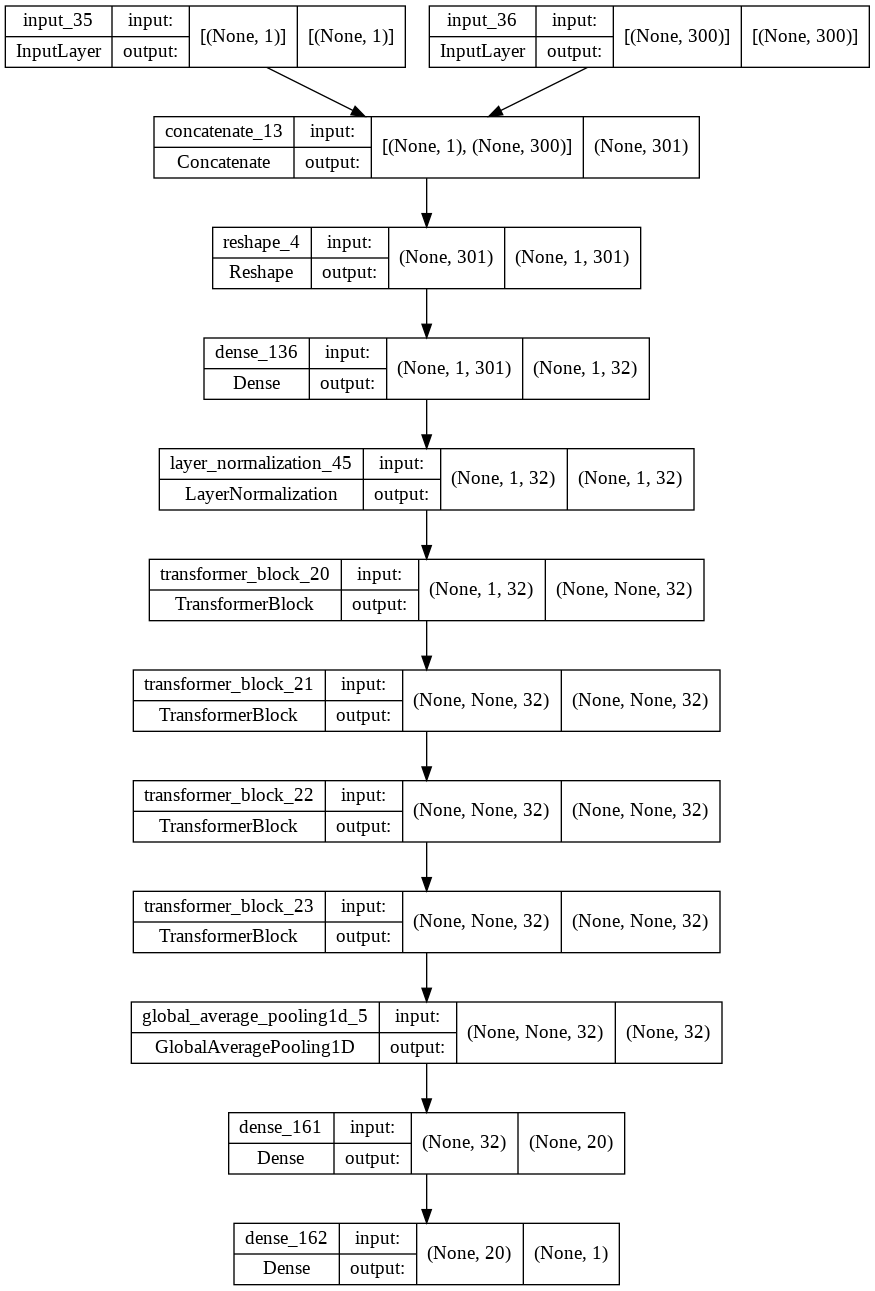

In [34]:
# Transformer Model
# https://www.kaggle.com/pratikskarnik/riiid-keras-transformer-starter
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
    def get_config(self):
        config = {
            "embed_dim" : self.embed_dim,
            "num_heads" : self.num_heads,
            "projection_dim" : self.projection_dim,
            "query_dense" : self.query_dense,
            "key_dense" : self.key_dense,
            "value_dense" : self.value_dense,
            "combine_heads" : self.combine_heads,
        }
        base_config = super(MultiHeadSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))  

# feat_dim : 長さが変わる時は要変更
feat_dim = 301 # 今回は特徴量の長さは固定
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim=GCF.EMBED_DIM, feat_dim=feat_dim, num_heads=GCF.N_HEAD, ff_dim=GCF.FF_DIM, rate=GCF.DROPOUT, **kwargs):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(num_heads=num_heads, embed_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = {
            "att" : self.att,
            "ffn" : self.ffn,
            "layernorm1" : self.layernorm1,
            "layernorm2" : self.layernorm2,
            "dropout1" : self.dropout1,
            "dropout2" : self.dropout2,
        }
        base_config = super(TransformerBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# https://www.kaggle.com/cdeotte/tensorflow-transformer-0-112
def create_transformer_model():
    # inputs = layers.Input(shape=(1, feat_dim))
    # investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.float16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)

    x = layers.Concatenate(axis=1)([investment_id_inputs, features_inputs])
    x = layers.Reshape((1, -1))(x)

    # "EMBEDDING LAYER"
    x = layers.Dense(GCF.EMBED_DIM)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(GCF.N_BLOCK):
        #x_old = x
        transformer_block = TransformerBlock(GCF.EMBED_DIM, feat_dim, GCF.N_HEAD, GCF.FF_DIM, GCF.DROPOUT)
        x = transformer_block(x)
        #x = 0.7*x + 0.3*x_old # SKIP CONNECTION
    
    x = layers.GlobalAveragePooling1D()(x)
    #x = layers.Dropout(0.2)(x)
    x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(0.2)(x)
    
    # REGRESSION HEAD
    outputs = layers.Dense(1, activation="linear")(x)
    
    model = keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[outputs])

    opt = tf.optimizers.Adam(config.lr)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(optimizer=opt, loss='mse', metrics=[rmse, correlation])
    return model

model = create_transformer_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [13]:
# Jane Street: Supervised Autoencoder MLP
# https://www.kaggle.com/gogo827jz/jane-street-supervised-autoencoder-mlp?scriptVersionId=73762661
class Params:
    num_columns = 300
    num_labels = 1 # 'num_labels': 5, 
    hidden_units = [96, 96, 896, 448, 448, 256]
    # dropout_rates = [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882, 0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
    dropout_rates = [0.00001, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882, 0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
    ls = 0
    lr = 1e-4 # 1e-3
params=Params()

def get_model_ae_mlp(num_columns=params.num_columns, num_labels=params.num_labels,\
                        hidden_units=params.hidden_units, dropout_rates=params.dropout_rates,\
                        ls=params.ls, lr=config.lr):

    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16) 
    inp = tf.keras.Input((num_columns, ), dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.BatchNormalization(name='batch_norm1')(investment_id_x) # add

    x0 = tf.keras.layers.BatchNormalization()(inp)

    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name = 'decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'ae_action')(x_ae)
    
    # x = tf.keras.layers.Concatenate(axis=1)([x0, encoder])
    x = tf.keras.layers.Concatenate(axis=1)([x0, investment_id_x, encoder])

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)
        
    out = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'action')(x)
    
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.models.Model(inputs = [investment_id_inputs, inp], outputs = [decoder, out_ae, out])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = {'decoder': tf.keras.losses.MeanSquaredError(), 
                          'ae_action': tf.keras.losses.MeanSquaredError(),
                          'action': tf.keras.losses.MeanSquaredError() 
                         },
                  metrics = {'decoder': tf.keras.metrics.MeanAbsoluteError(name = 'MAE'), 
                             'ae_action': tf.keras.metrics.MeanAbsoluteError(name = 'MAE'),
                             'action': ['mse', "mae", "mape", rmse, correlation]
                            }, 
                 )
    return model
# if not TEST:
#     scores = []
#     batch_size = 4096
#     gkf = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = group_gap)
#     for fold, (tr, te) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
#         ckp_path = f'JSModel_{fold}.hdf5'
#         model = create_ae_mlp(**params)
#         ckp = ModelCheckpoint(ckp_path, monitor = 'val_action_AUC', verbose = 0, 
#                               save_best_only = True, save_weights_only = True, mode = 'max')
#         es = EarlyStopping(monitor = 'val_action_AUC', min_delta = 1e-4, patience = 10, mode = 'max', 
#                            baseline = None, restore_best_weights = True, verbose = 0)
#         history = model.fit(X[tr], [X[tr], y[tr], y[tr]], validation_data = (X[te], [X[te], y[te], y[te]]), 
#                             sample_weight = sw[tr], 
#                             epochs = 100, batch_size = batch_size, callbacks = [ckp, es], verbose = 0)
#         hist = pd.DataFrame(history.history)
#         score = hist['val_action_AUC'].max()
#         print(f'Fold {fold} ROC AUC:\t', score)
#         scores.append(score)

#         K.clear_session()
#         del model
#         rubbish = gc.collect()
    
#     print('Weighted Average CV Score:', weighted_average(scores))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 300)         1200        ['input_2[0][0]']                
 alization)                                                                                   

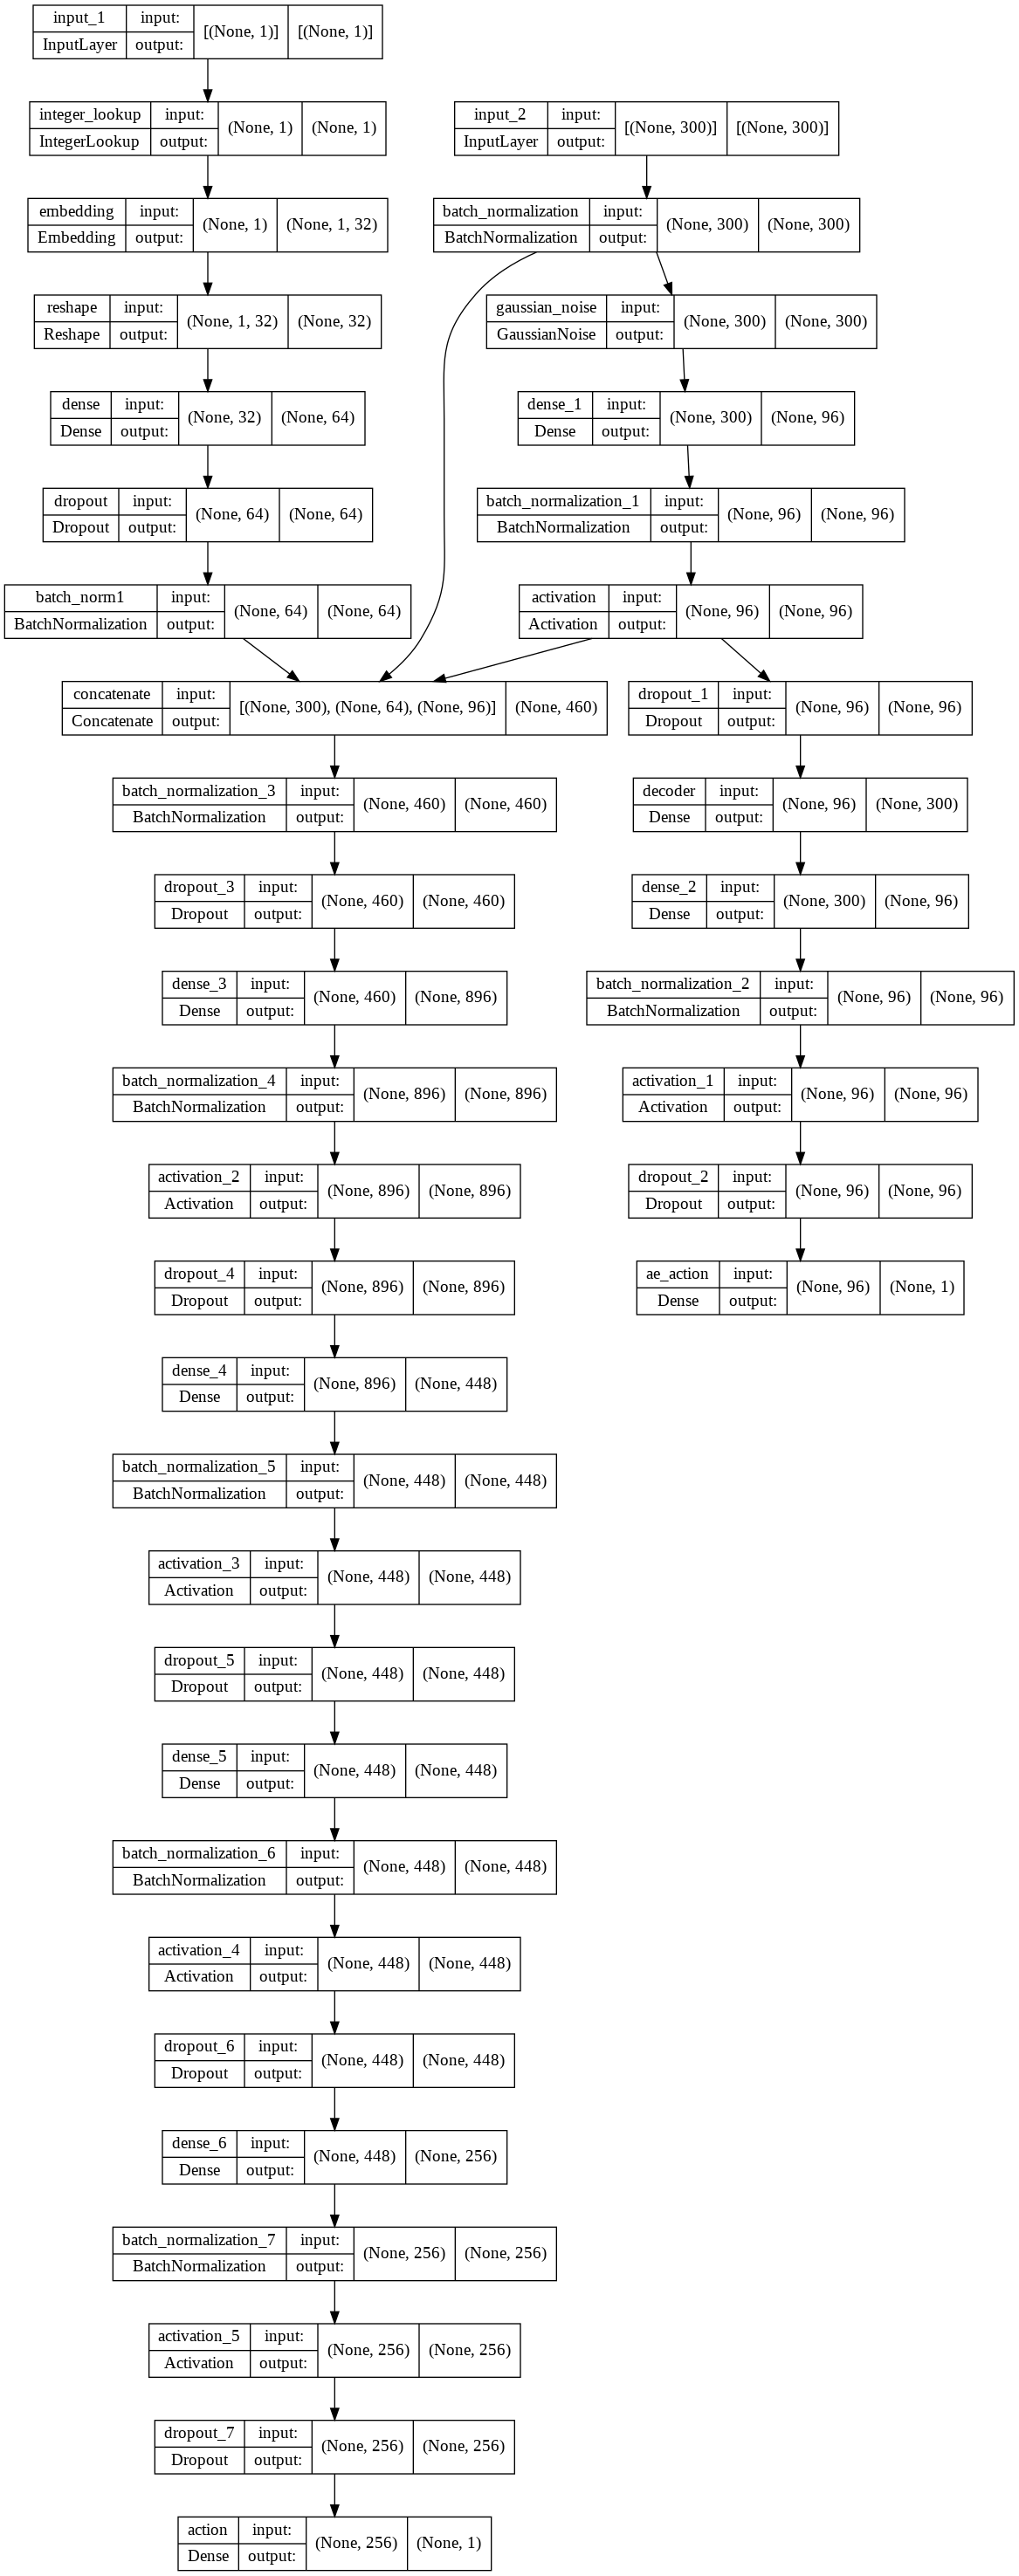

In [14]:
model = get_model_ae_mlp()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Make Tensorflow dataset

In [35]:
# if not preserve tf record
def preprocess_train(investment_id, feature, target):
    return (investment_id, feature), target

def make_train_dataset(feature, investment_id, target, batch_size=4096):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature, target)))
    ds = ds.shuffle(batch_size * 4)
    ds = ds.map(preprocess_train)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
A = pd.DataFrame([[1,2,3],[2,3,4]])
for t in tf.data.Dataset.from_tensor_slices(A):#.take(1):
    print(t)

tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([2 3 4], shape=(3,), dtype=int64)


## Model Training

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/30
95/95 [==============================] - 6s 46ms/step - loss: 2.7258 - mse: 0.8613 - mae: 0.6338 - mape: 90970.7422 - rmse: 0.9280 - correlation: 0.8876 - val_loss: 0.9981 - val_mse: 0.8250 - val_mae: 0.6567 - val_mape: 109666.0156 - val_rmse: 0.9083 - val_correlation: 0.8744
Epoch 2/30
95/95 [==============================] - 2s 22ms/step - loss: 0.9222 - mse: 0.8621 - mae: 0.6348 - mape: 51372.4414 - rmse: 0.9285 - correlation: 0.8876 - val_loss: 0.8382 - val_mse: 0.8215 - val_mae: 0.6542 - val_mape: 88827.0312 - val_rmse: 0.9063 - val_correlation: 0.8596
Epoch 3/30
95/95 [==============================] - 2s 21ms/step - loss: 0.8664 - mse: 0.8582 - mae: 0.6335 - mape: 55691.5273 - rmse: 0.9264 - correlation: 0.8713 - val_loss: 0.8269 - val_mse: 0.8223 - val_mae: 0.6583 - val_mape: 90897.1250 - val_rmse: 0.9068 - val_correlation: 0.8556
Epoch 4/30
95/95 [==============================] - 2s 21ms/step - loss: 0.8587 - mse: 0.8559 - mae: 0.6325 - mape: 55977.6484 - rmse: 0.9

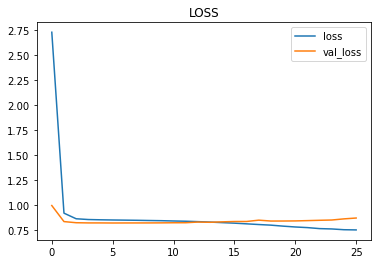

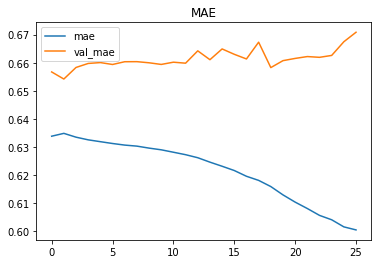

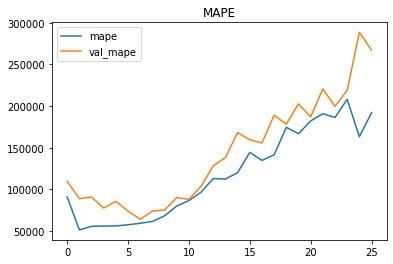

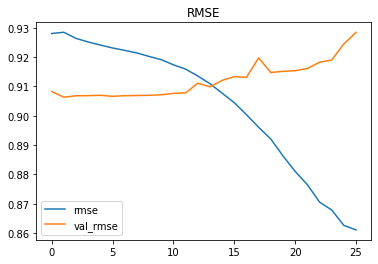

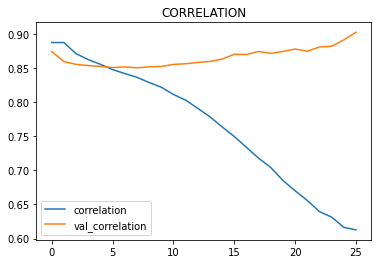

Pearson Score: 0.14848590297658662
Epoch 1/30
188/188 [==============================] - 9s 39ms/step - loss: 1.8120 - mse: 0.8411 - mae: 0.6424 - mape: 95927.5391 - rmse: 0.9171 - correlation: 0.8726 - val_loss: 0.8439 - val_mse: 0.8243 - val_mae: 0.6488 - val_mape: 117373.5078 - val_rmse: 0.9079 - val_correlation: 0.8630
Epoch 2/30
188/188 [==============================] - 3s 16ms/step - loss: 0.8500 - mse: 0.8436 - mae: 0.6433 - mape: 65870.6406 - rmse: 0.9185 - correlation: 0.8824 - val_loss: 0.8319 - val_mse: 0.8276 - val_mae: 0.6512 - val_mape: 125066.1562 - val_rmse: 0.9097 - val_correlation: 0.8634
Epoch 3/30
188/188 [==============================] - 3s 16ms/step - loss: 0.8442 - mse: 0.8420 - mae: 0.6426 - mape: 67747.1250 - rmse: 0.9176 - correlation: 0.8751 - val_loss: 0.8085 - val_mse: 0.8041 - val_mae: 0.6459 - val_mape: 67989.4375 - val_rmse: 0.8967 - val_correlation: 0.8627
Epoch 4/30
188/188 [==============================] - 3s 16ms/step - loss: 0.8395 - mse: 0.8364 

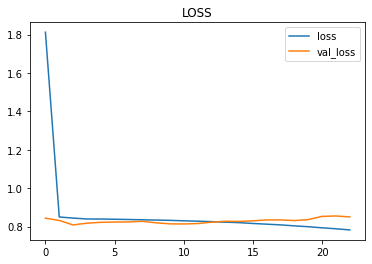

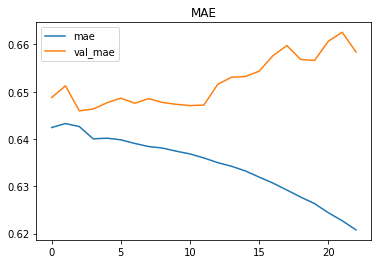

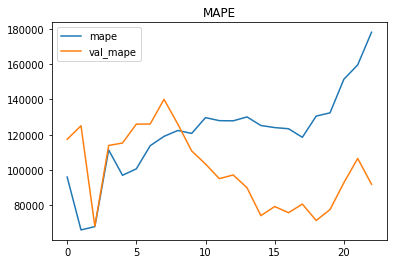

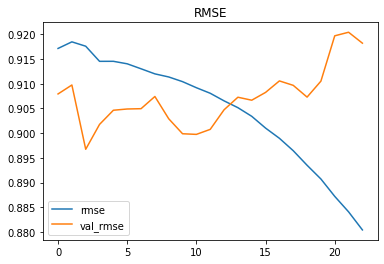

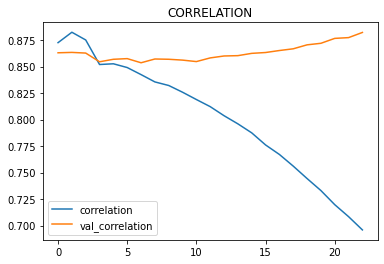

Pearson Score: 0.14716710484145284
Epoch 1/30
274/274 [==============================] - 11s 33ms/step - loss: 1.4909 - mse: 0.8260 - mae: 0.6452 - mape: 83100.4922 - rmse: 0.9089 - correlation: 0.8671 - val_loss: 0.8552 - val_mse: 0.8510 - val_mae: 0.6225 - val_mape: 96677.9844 - val_rmse: 0.9225 - val_correlation: 0.8800
Epoch 2/30
274/274 [==============================] - 4s 15ms/step - loss: 0.8245 - mse: 0.8218 - mae: 0.6437 - mape: 88600.6953 - rmse: 0.9065 - correlation: 0.8508 - val_loss: 0.8526 - val_mse: 0.8499 - val_mae: 0.6270 - val_mape: 95971.3750 - val_rmse: 0.9219 - val_correlation: 0.8756
Epoch 3/30
274/274 [==============================] - 4s 15ms/step - loss: 0.8214 - mse: 0.8189 - mae: 0.6423 - mape: 92551.7109 - rmse: 0.9049 - correlation: 0.8413 - val_loss: 0.8550 - val_mse: 0.8522 - val_mae: 0.6319 - val_mape: 89883.2891 - val_rmse: 0.9232 - val_correlation: 0.8781
Epoch 4/30
274/274 [==============================] - 4s 15ms/step - loss: 0.8194 - mse: 0.8170 -

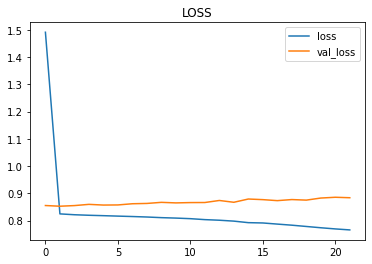

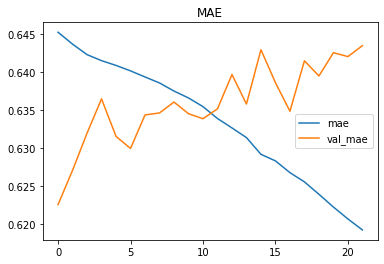

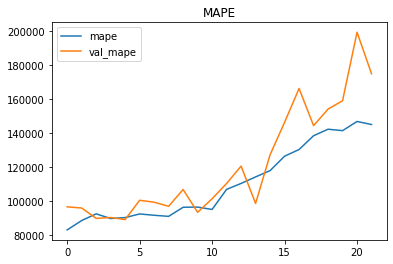

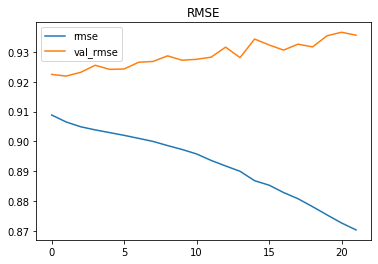

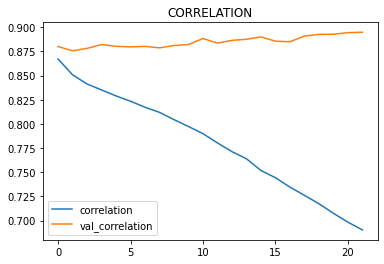

Pearson Score: 0.12436255712749322


In [ ]:
##### BASE MODEL #####
# models = []
# features = [f"f_{i}" for i in range(300)]
# gkf = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = group_gap)
# for fold, (tra_idx, val_idx) in tqdm(enumerate(gkf.split(train['investment_id'].values, train['investment_id'].values, train['time_id'].values)), total=n_splits):

#     valid_ds = make_train_dataset(train.loc[val_idx,features], train.loc[val_idx,'investment_id'], train.loc[val_idx,'target'])
#     model = get_model()
#     if config.is_training:
#         train_ds = make_train_dataset(train.loc[tra_idx, features], train.loc[tra_idx, 'investment_id'], train.loc[tra_idx, 'target'])
#         checkpoint = keras.callbacks.ModelCheckpoint(f"model_{fold}.tf", monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
#         early_stop = keras.callbacks.EarlyStopping(patience=20)
#         history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
#         model.load_weights(f"model_{fold}.tf")
#         for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
#             pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
#             plt.title(metric.upper())
#             plt.show()
#     else:
#         model.load_weights(f"{config.output_dataset_path}model_{fold}.tf")
#     y_vals = []
#     for _, y in valid_ds:
#         y_vals += list(y.numpy().reshape(-1))
#     y_val = np.array(y_vals)
#     pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
#     models.append(model)
#     print(f"Pearson Score: {pearson_score}")

In [36]:
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["investment_id"], item["features"]), item["target"]

def make_dataset(file_paths, batch_size=config.batch_size, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
# data_path = config.tf_record_dataset_path
# train_path = data_path+"/fold_0_train.tfrecords"
# tmp = make_dataset([train_path])

In [ ]:
config.output_result_path

'./res'

In [ ]:
log_df = pd.DataFrame(columns=['Model', 'lr', 'epochs', 'batch', 'cv', 'fold', 'lr_scheduler', 'end_epochs', 'corr'])
if not os.path.exists(config.output_result_path+'/result.csv'):
    log_df.to_csv(config.output_result_path+'/result.csv')
    print('make result.csv')

In [ ]:
models = []
log_df = pd.read_csv(config.output_result_path+'/result.csv')
preds = []
targets = []
for i in tqdm(range(config.n_splits), total=config.n_splits):
    log = {'Model':config.model, 'lr':config.lr, 'epochs':config.epochs, 'batch':config.batch_size, 'cv':config.cv, 'fold':i, 'lr_scheduler':config.lr_scheduler}
    print(f'=======================fold : {i}=======================')
    train_path = f"{config.tf_record_dataset_path}/{config.cv}/{config.cv}_fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}/{config.cv}/{config.cv}_fold_{i}_test.tfrecords"
    valid_ds = make_dataset([valid_path], mode="valid")
    ################################
    model = get_model()
    ################################
    if config.is_training:
        train_ds = make_dataset([train_path])
        batch_length = len(list(train_ds))
        checkpoint = keras.callbacks.ModelCheckpoint(f"{config.output_dataset_path}/{config.model}_{config.cv}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf"\
                                                     , monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=config.patience)
        # scheduler = keras.callbacks.LearningRateScheduler(config.lr_scheduler)
        lr, ts, wlr, ws, hbrs = config.warm_up_lr(config.batch_size*batch_length)
        lr_scheduler = eval(config.lr_scheduler)(learning_rate_base = lr,
                                           total_steps = ts,
                                           warmup_steps = ws,
                                           hold_base_rate_steps=hbrs)
        history = model.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, early_stop, lr_scheduler])
        model.load_weights(f"{config.output_dataset_path}/{config.model}_{config.cv}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf")


        end_epochs = len(history.history['loss'])
        log['end_epochs'] = end_epochs
        scheduler_plot(lr_scheduler, ts, lr)
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}/{config.model}_{config.cv}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf")

    y_vals = []
    for _, y in valid_ds:
        y_vals += y.numpy().reshape(-1).tolist()

    targets += y_vals
    pred = model.predict(valid_ds).reshape(-1)
    preds += pred.tolist()

    pearson_score = stats.pearsonr(pred, np.array(y_vals))[0]

    log['corr'] = pearson_score
    log_df = log_df.append(log, ignore_index=True)
    models.append(model)
    print(f"Pearson Score: {pearson_score}")

log_df.to_csv(config.output_result_path+'/result.csv', index=False)
print('-'*60)
# この計算はCVの長さが違うから間違ってる
score = stats.pearsonr(np.array(preds), np.array(targets))[0]
print(f'TOTAL SCORE : {score}')

In [ ]:
# if not TEST:
#     scores = []
#     batch_size = 4096
#     gkf = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = group_gap)
#     for fold, (tr, te) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
#         ckp_path = f'JSModel_{fold}.hdf5'
#         model = create_ae_mlp(**params)
#         ckp = ModelCheckpoint(ckp_path, monitor = 'val_action_AUC', verbose = 0, 
#                               save_best_only = True, save_weights_only = True, mode = 'max')
#         es = EarlyStopping(monitor = 'val_action_AUC', min_delta = 1e-4, patience = 10, mode = 'max', 
#                            baseline = None, restore_best_weights = True, verbose = 0)
#         history = model.fit(X[tr], [X[tr], y[tr], y[tr]], validation_data = (X[te], [X[te], y[te], y[te]]), 
#                             sample_weight = sw[tr], 
#                             epochs = 100, batch_size = batch_size, callbacks = [ckp, es], verbose = 0)
#         hist = pd.DataFrame(history.history)
#         score = hist['val_action_AUC'].max()
#         print(f'Fold {fold} ROC AUC:\t', score)
#         scores.append(score)

#         K.clear_session()
#         del model
#         rubbish = gc.collect()
    
#     print('Weighted Average CV Score:', weighted_average(scores))

## AutoEncoder

In [17]:
# https://qiita.com/everylittle/items/a7c31b08d2f76c886a92
def decode_function(record_bytes): # binaryデータを辞書型に変換
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item): # datasetの形式で返す。
    return (item['investment_id'],item["features"]), (item["features"], item["target"], item["target"])
    # return (item["investment_id"], item["features"]), item["target"]

def parse_example(example):
    features = tf.io.parse_example(
        example,
        features={
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
        }
    )
    return (features['investment_id'], features['features']), (features['features'], features['target'], features['target'])


def make_dataset(file_paths, batch_size=config.batch_size, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
# data_path = config.tf_record_dataset_path
# train_path = data_path+"/fold_0_train.tfrecords"
# tmp = make_dataset([train_path])

In [18]:
models = []
log_df = pd.read_csv(config.output_result_path+'/result.csv')
preds = []
targets = []
for i in tqdm(range(config.n_splits), total=config.n_splits):
    log = {'Model':config.model, 'lr':config.lr, 'epochs':config.epochs, 'batch':config.batch_size, 'cv':config.cv, 'fold':i, 'lr_scheduler':config.lr_scheduler}
    print(f'=======================fold : {i}=======================')
    train_path = f"{config.tf_record_dataset_path}/{config.cv}/{config.cv}_fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}/{config.cv}/{config.cv}_fold_{i}_test.tfrecords"
    valid_ds = make_dataset([valid_path], mode="valid")
    model = get_model_ae_mlp()
    if config.is_training:
        train_ds = make_dataset([train_path])
        batch_length = len(list(train_ds))
        checkpoint = keras.callbacks.ModelCheckpoint(f"{config.output_dataset_path}/{config.model}_{config.cv}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf"\
                                                     , monitor="val_action_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=config.patience)
        lr, ts, wlr, ws, hbrs = config.warm_up_lr(config.batch_size*batch_length)
        lr_scheduler = eval(config.lr_scheduler)(learning_rate_base = lr,
                                           total_steps = ts,
                                           warmup_steps = ws,
                                           hold_base_rate_steps=hbrs)
        # train
        history = model.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoint, early_stop, lr_scheduler])
        model.load_weights(f"{config.output_dataset_path}/{config.model}_{config.cv}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf")

        end_epochs = len(history.history['loss'])
        log['end_epochs'] = end_epochs
        scheduler_plot(lr_scheduler, ts, lr)
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[f'action_{metric}', f"val_action_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}/{config.model}_{config.cv}_lr{config.lr}_epochs{config.epochs}_batch{config.batch_size}_fold{i}.tf")

    y_vals = []
    for _, y in valid_ds:
        y = y[2]
        y_vals += y.numpy().reshape(-1).tolist()

    targets += y_vals
    pred = model.predict(valid_ds)[2].reshape(-1)
    preds += pred.tolist()

    pearson_score = stats.pearsonr(pred, np.array(y_vals))[0]

    log['corr'] = pearson_score
    log_df = log_df.append(log, ignore_index=True)
    models.append(model)
    print(f"Pearson Score: {pearson_score}")

log_df.to_csv(config.output_result_path+'/result.csv', index=False)
print('-'*60)
# この計算はCVの長さが違うから間違ってる
score = stats.pearsonr(np.array(preds), np.array(targets))[0]
print(f'TOTAL SCORE : {score}')

  0%|          | 0/6 [00:00<?, ?it/s]

=======================fold : 0=======================
Epoch 1/300
706/706 [==============================] - 36s 40ms/step - loss: 3.4525 - decoder_loss: 1.1924 - ae_action_loss: 1.1477 - action_loss: 1.1125 - decoder_MAE: 0.7863 - ae_action_MAE: 0.8337 - action_mse: 1.1125 - action_mae: 0.8086 - action_mape: 470408.1250 - action_rmse: 1.0547 - action_correlation: 1.0080 - val_loss: 3.2308 - val_decoder_loss: 1.2027 - val_ae_action_loss: 1.0538 - val_action_loss: 0.9744 - val_decoder_MAE: 0.7868 - val_ae_action_MAE: 0.7587 - val_action_mse: 0.9744 - val_action_mae: 0.7120 - val_action_mape: 245312.9531 - val_action_rmse: 0.9871 - val_action_correlation: 1.0163
Epoch 2/300
706/706 [==============================] - 21s 30ms/step - loss: 2.8847 - decoder_loss: 0.9525 - ae_action_loss: 0.9997 - action_loss: 0.9326 - decoder_MAE: 0.6918 - ae_action_MAE: 0.7400 - action_mse: 0.9326 - action_mae: 0.6961 - action_mape: 515990.0312 - action_rmse: 0.9657 - action_correlation: 0.9971 - val_loss

KeyboardInterrupt: ignored

In [ ]:
pd.read_csv(config.output_result_path+'/result.csv')

NameError: ignored

## Submission

In [ ]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
features = [f"f_{i}" for i in range(300)]
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df) 